In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [4]:
df <- read.table('uncon_v_con_shock_MR_ROI24_with_covariates.txt',header = TRUE)
head(df)

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,vmPFC,0.0915,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,PCC1,0.5290,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,PCC2,0.3904,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,rPAG1,0.6907,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,lPAG1,-0.0709,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,rvAI,0.1475,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


# **1. Bayesian Multi-level modeling**

## **Model**

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + \epsilon$$

## **Priors**
$\nu_{ROI} \sim \Gamma(1,0.5)$  
$\nu_{SUB} \sim \Gamma(1,0.5)$  
$\alpha \sim Student\_t(3,0,10)$  
$\nu \sim \Gamma(1,0.5)$  
$\sigma_{\epsilon} \sim Student\_t(3,0,10)$    
$\sigma_{ROI} \sim Student\_t(3,0,10)$  
$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$  
$\sigma_{SUB} \sim Student\_t(3,0,10)$  
$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$  

In [22]:
mod = '1'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student"))+(',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[1:2] <- "gamma(1,0.5)"
priorRBA$prior[4] <- "gamma(1,0.5)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,"gamma(1,0.5)",df,,ROI,,,,
2,"gamma(1,0.5)",df,,Subj,,,,
3,"student_t(3, 0, 10)",Intercept,,,,,,
4,"gamma(1,0.5)",nu,,,,,,
5,"student_t(3, 0, 10)",sd,,,,,,
6,,sd,,ROI,,,,
7,,sd,Intercept,ROI,,,,
8,,sd,,Subj,,,,
9,,sd,Intercept,Subj,,,,


In [25]:
iterations <- 10000
chains <- 4
SCALE <- 1
dataTable <- select(df,c('Subj','ROI','Y'))
head(dataTable)

,Subj,ROI,Y
,<fct>,<fct>,<dbl>
1,P00,vmPFC,0.0915
2,P00,PCC1,0.5290
3,P00,PCC2,0.3904
4,P00,rPAG1,0.6907
5,P00,lPAG1,-0.0709
6,P00,rvAI,0.1475


In [26]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '9cc16ea9d14be96dc1580315bd7b3437' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 298.21 seconds (Warm-up)
Chain 1:                247.31 seconds (Sampling)


Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”


In [27]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + (1 | gr(Subj, dist = "student")) + (1 | gr(ROI, dist = "student")) 
   Data: dataTable (Number of observations: 1464) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~ROI (Number of levels: 24) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df               20.97     14.03     3.54    55.72 1.00      765     1068
sd(Intercept)     0.05      0.01     0.03     0.08 1.00     4770     6913

~Subj (Number of levels: 61) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
df               22.18     13.49     4.73    56.39 1.02      319      522
sd(Intercept)     0.14      0.02     0.11     0.18 1.00     1821     2262

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.04      0.02    -0.00     0.09 1.00  

In [28]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

In [29]:
ns <- iterations*chains/2

In [30]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

## **1.1. Bayesian Summary of ROI effects**

In [31]:
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', 'Intercept'),sep = '\n')
ps0 <- psROI(aa, bb, 'Intercept') # Global intercept + ROI intercepts
gg_brm <- sumROI(ps0, ns, 4)
cat(capture.output(gg_brm),sep='\n')

===== Summary of region effects for Intercept (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0141 0.0346 0.6610 -0.0545 -0.0433  0.0144 0.0700 0.0804
Amygdala_BLBM_La_L  0.0227 0.0366 0.7354 -0.0508 -0.0380  0.0232 0.0823 0.0945
Amygdala_BLBM_La_R  0.0566 0.0367 0.9396 -0.0158 -0.0037  0.0565 0.1172 0.1289
Amygdala_CeME_L     0.0613 0.0398 0.9398 -0.0156 -0.0034  0.0612 0.1273 0.1404
Amygdala_CeME_R     0.0336 0.0386 0.8119 -0.0440 -0.0302  0.0343 0.0966 0.1085
lBNST               0.1164 0.0434 0.9982  0.0355  0.0473  0.1154 0.1902 0.2056
lCa                 0.0542 0.0334 0.9477 -0.0108 -0.0007  0.0540 0.1094 0.1197
ldAI                0.0998 0.0372 0.9978  0.0295  0.0403  0.0991 0.1622 0.1753
lPa                 0.0841 0.0342 0.9940  0.0182  0.0291  0.0833 0.1413 0.1524
lPAG1               0.0269 0.0370 0.7700 -0.0476 -0.0343  0.0275 0.0862 0.0987
lPI                 0.0094 0.0354 0.6102 -0.0612 -0.0498  0.0094 

# **2. Conventional GLM**
- akin to one-sample t-test per ROI data

In [34]:
mm <- list()
#GLM <- as.formula(paste('Y ~ 1'))
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM

In [35]:
for(ii in levels(dataTable$ROI)) mm[[ii]] = lm(GLM, data=dataTable[dataTable$ROI==ii,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')

In [36]:
# number of ROIs
nR <- nlevels(dataTable$ROI)

sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

## **2.1. Conventional Summary of ROI effects**

In [37]:
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', 'Intercept'),sep='\n')
gg_glm <- sumGLM(ll, 'Intercept', nR, nn[[ii]]$df, 4)
cat(capture.output(gg_glm), sep = '\n', append=TRUE)
cat('\n',sep = '\n', append=TRUE)

===== Summary of region effects under GLM for Intercept (for reference only): no adjustment for multiplicity =====
                      mean     SD 2-sided-p    2.5%      5%     50%    95%
ACC                 0.0129 0.0334    0.7011 -0.4110 -0.0429  0.0129 0.2235
Amygdala_BLBM_La_L  0.0800 0.0589    0.1794 -0.6683 -0.0184  0.0800 0.4518
Amygdala_BLBM_La_R  0.0564 0.0589    0.3424 -0.6922 -0.0420  0.0564 0.4284
Amygdala_CeME_L     0.0693 0.0708    0.3318 -0.8307 -0.0490  0.0693 0.5165
Amygdala_CeME_R     0.0070 0.0725    0.9233 -0.9141 -0.1141  0.0070 0.4647
lBNST               0.1608 0.0631    0.0134 -0.6409  0.0554  0.1608 0.5592
lCa                 0.0536 0.0281    0.0609 -0.3029  0.0067  0.0536 0.2307
ldAI                0.1534 0.0456    0.0013 -0.4262  0.0772  0.1534 0.4414
lPa                 0.1102 0.0283    0.0003 -0.2500  0.0628  0.1102 0.2891
lPAG1               0.0239 0.0444    0.5928 -0.5400 -0.0503  0.0239 0.3040
lPI                -0.0040 0.0281    0.8861 -0.3605 -0.0509 

In [38]:
gg_brm$ROI <- factor(rownames(gg_brm))
gg_glm = as.data.frame(gg_glm)
gg_glm$ROI = factor(rownames(gg_glm))

# **3. Posterior Plots**

## **3.1 Posteriors with overall intercept**

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”


[1] "1.00"

Picking joint bandwidth of 0.00468



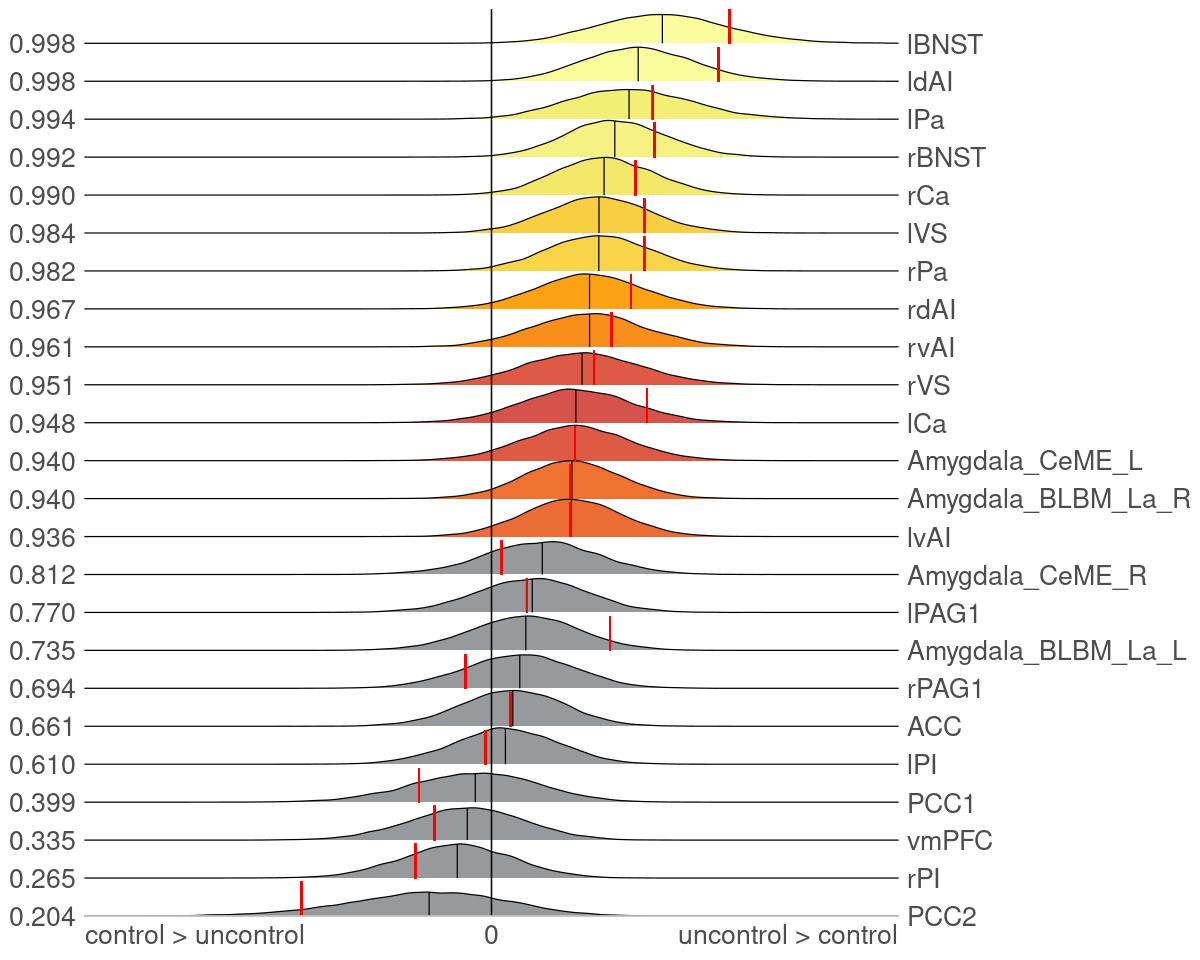

In [39]:
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.25, 0.25)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))

Red vertical lines: GLM